In [96]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
import utility
import pandas as pd
import json

# O(n)
def bottomk_indices(v, k):
    return np.argpartition(v, k)[:k]

def not_indices(indices, shape):
    new_indices = np.ones(shape, dtype=bool)
    new_indices[indices] = False
    return new_indices

def normalize(x):
    min = np.min(x)
    max = np.max(x)
    if min == max:
        return x
    return ((x - min) /
            (max - min))

def clamp(x):
    return np.clip(x, 0, 1)

In [12]:
raw_data_paths = list(Path("../stimuli/obvious_gaussian_clusters").iterdir())
raw_data_path = list(Path("../stimuli/obvious_gaussian_clusters").iterdir())[9]

In [3]:
raw_data = np.load(raw_data_path)

## Structure of data

* x
* y
* cluster_number

In [4]:
print("Shape: {}".format(raw_data.shape))
raw_data[:10]

Shape: (20, 3)


array([[408.53980811,  88.21579982,   0.        ],
       [316.3766974 ,  56.95052603,   0.        ],
       [389.33152022,  44.51111297,   0.        ],
       [399.01064351,  27.12535716,   0.        ],
       [355.07352117,  48.4739435 ,   0.        ],
       [451.0791624 , 727.97922399,   1.        ],
       [496.69911714, 726.94652974,   1.        ],
       [442.88615495, 663.5421761 ,   1.        ],
       [445.22390949, 718.08101281,   1.        ],
       [442.50009505, 667.15766348,   1.        ]])

In [5]:
raw_points = raw_data[:, :2]

In [6]:
# parameters
number_of_neurons_in_network = 100
bottomk_ratio = 0.1
learning_rate = 0.1
training_iterations = 14

In [69]:
class Network:
    
    def __init__(self, D):
        # D are the values of the neurons
        self.D = D
        # W are the weights of the neurons
        self.W = np.ones(D.shape[0]) / 2
        self.bottomk_number = round(bottomk_ratio * number_of_neurons_in_network)
    
    @classmethod
    def generate_initial(cls, X):
        n_dims = X.shape[1]
        ranges = []
        for col_idx in range(n_dims):
            col_values = X[:, col_idx]
            min = np.min(col_values)
            max = np.max(col_values)
            ranges.append((min, max))

        final_transposed = []
        for min, max in ranges:
            final_transposed.append(np.random.uniform(min, max, number_of_neurons_in_network))

        return cls(np.array(final_transposed).T)
    
    def plot(self, X, edge=True):
        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], color="red")
        facecolors = np.array([0, 1, 0]) * np.ones(len(self.W)).reshape(len(self.W), 1).astype('int')
        facecolors = np.hstack((facecolors, self.W.reshape(-1, 1)))
        ax.scatter(self.D[:, 0], self.D[:, 1], facecolor=facecolors, edgecolor='b' if edge else None)
        return ax
    
    def train_iter(self, raw_points):
                # experimental training loop
        shape = raw_points.shape

         # inhibition amount

        inhibition_ratio  = 1 - self.get_raw_activation()
        self.bottomk_number = round((bottomk_ratio * number_of_neurons_in_network) +
                                    (bottomk_ratio * number_of_neurons_in_network) *
                                    inhibition_ratio)

        # print(((bottomk_ratio * number_of_neurons_in_network) ** inhibition_ratio) / (bottomk_ratio * number_of_neurons_in_network))

        # data point similarity
        for data_point in raw_points:
            difference_vectors =  self.D - data_point.reshape(1, shape[1])
            euclidean_distances = np.linalg.norm(difference_vectors, ord=2, axis=1)
            nearby_indices = bottomk_indices(euclidean_distances, self.bottomk_number)
            close_neurons_distances = euclidean_distances[nearby_indices]
            
            # hebbian part, move them closer, this is very important
            self.D[nearby_indices] = self.D[nearby_indices] - learning_rate * self.W[nearby_indices].reshape(-1, 1) * difference_vectors[nearby_indices]
            
            # reduce weights of far away points, this seems fairly important to kill neurons that are not doing anything
            weight_change_reduction_indices = not_indices(nearby_indices, self.W.shape)
            self.W[weight_change_reduction_indices] = clamp(self.W[weight_change_reduction_indices] - 0.01)

            # increase weight of the closest point
            #i = np.argmin(euclidean_distances)
            #self.W[i] = clamp(self.W[i] + 0.2)
            self.W[nearby_indices] = clamp(self.W[nearby_indices] + self.W[nearby_indices] * 0.5)
            

            
            # tan(x) based inhibition
            #normalized_neuron_distances = normalize(close_neurons_distances)
        #     weight_changes = np.tan(normalized_neuron_distances - 0.5) * self.W[nearby_indices]
        #     print(weight_changes)
        #     self.W[nearby_indices] = clamp(self.W[nearby_indices] + weight_changes)
            
        # neuron proximity based inhibition
        for idx in range(0, len(self.D)):
            neuron = self.D[idx]
            neuron_weight = self.W[idx]
            difference_vectors_from_other_neurons = self.D - neuron.reshape(1, shape[1])
            euclidean_distances = np.linalg.norm(difference_vectors_from_other_neurons, ord=2, axis=1)
            # plus one because the neuron itself is in the dataset
            near_neuron_indices = bottomk_indices(euclidean_distances, self.bottomk_number + 1)
            weight_change_neuron_indicies = near_neuron_indices[near_neuron_indices != idx]
            normalized_distances = normalize(euclidean_distances[weight_change_neuron_indicies])
            weight_changes = (1 - normalized_distances) * neuron_weight
            self.W[weight_change_neuron_indicies] = clamp(self.W[weight_change_neuron_indicies] - weight_changes)

                
          
        # pruning step
        # neurons_to_prune = []
        # for idx in range(0, len(self.D)):
        #     if self.W[idx] < 0.001:
        #         neurons_to_prune.append(idx)

        #neurons_to_keep = not_indices(neurons_to_prune, self.W.shape)
        #self.D = self.D[neurons_to_keep]
        #self.W = self.W[neurons_to_keep]
        #bottomk_number = round(len(self.D) * bottomk_ratio)
        #bottomk_number = round(bottomk_number * (1 - bottomk_ratio))
            
            # reduce weights of nearby points
            # self.W[nearby_indices] = clamp(self.W[nearby_indices] - (0.01 * inhibition_ratio), 0, 1)
            
    def get_cluster_representation(self, raw_points):
        cluster_centroid_values = self.D[self.W > 0.001]
        cluster_indicies = []
        for point in raw_points:
            euclidean_distances = np.linalg.norm(point.reshape(1, -1) - cluster_centroid_values, ord=2, axis=1)
            cluster_indicies.append(np.argmin(euclidean_distances))
        return np.hstack((raw_points, np.array(cluster_indicies).reshape(-1, 1)))

    
    def get_raw_activation(self):
        return np.sum(self.W) / self.W.shape[0]
    
    def fit(self, raw_points):
        for _ in range(training_iterations):
            self.train_iter(raw_points)
        return self.get_cluster_representation(raw_points)
    
    def __repr__(self):
        return f"<Network D={len(self.D)}>"


<AxesSubplot:>

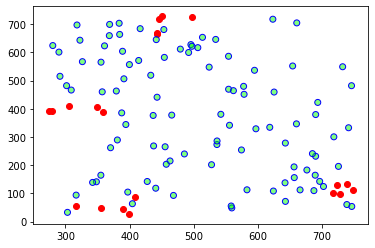

In [8]:
network = Network.generate_initial(raw_points)
network.plot(raw_points)

<AxesSubplot:>

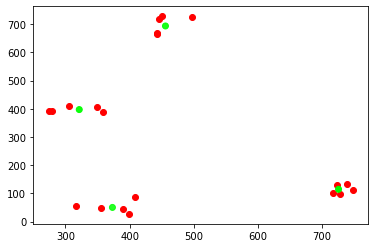

In [9]:
for _ in range(training_iterations):
    network.train_iter(raw_points)

network.plot(raw_points, edge=False)

In [10]:
utility.calc_fowlkes_mallows(network.get_cluster_representation(raw_points), raw_data)

1.0

In [11]:
utility.conv_mat_representation(utility.conv_list_representation(raw_data))

array([[408.53980811,  88.21579982,   0.        ],
       [316.3766974 ,  56.95052603,   0.        ],
       [389.33152022,  44.51111297,   0.        ],
       [399.01064351,  27.12535716,   0.        ],
       [355.07352117,  48.4739435 ,   0.        ],
       [451.0791624 , 727.97922399,   1.        ],
       [496.69911714, 726.94652974,   1.        ],
       [442.88615495, 663.5421761 ,   1.        ],
       [445.22390949, 718.08101281,   1.        ],
       [442.50009505, 667.15766348,   1.        ],
       [273.56383427, 390.25908282,   2.        ],
       [349.39722046, 406.8242298 ,   2.        ],
       [358.61354637, 387.19187408,   2.        ],
       [279.20381163, 390.94809632,   2.        ],
       [305.18165839, 410.90402633,   2.        ],
       [748.12077302, 111.74863732,   3.        ],
       [723.54450717, 128.63455631,   3.        ],
       [728.71086338,  97.6115543 ,   3.        ],
       [717.56625883, 101.80675677,   3.        ],
       [738.52401525, 131.97128

In [75]:
rows = []
for path in raw_data_paths:
    raw_data = np.load(path)
    raw_points = raw_data[:,:2]
    network = Network.generate_initial(raw_points)
    cluster_rep = network.fit(raw_points)
    rows.append((path, utility.calc_fowlkes_mallows(cluster_rep, raw_data), len(set(cluster_rep[:,2]))))
df = pd.DataFrame.from_records(rows, columns = ('filename', 'fm', 'number_of_clusters'))
df

,filename,fm,number_of_clusters
0,../stimuli/obvious_gaussian_clusters/3179a79d-...,0.921954,5
1,../stimuli/obvious_gaussian_clusters/dbd36574-...,1.000000,4
2,../stimuli/obvious_gaussian_clusters/face4f91-...,1.000000,4
3,../stimuli/obvious_gaussian_clusters/a7de7df0-...,1.000000,4
4,../stimuli/obvious_gaussian_clusters/9d2e1b83-...,1.000000,4
5,../stimuli/obvious_gaussian_clusters/71651a6c-...,1.000000,4
6,../stimuli/obvious_gaussian_clusters/5df2f663-...,1.000000,4
7,../stimuli/obvious_gaussian_clusters/d273000a-...,1.000000,4
8,../stimuli/obvious_gaussian_clusters/9f8c4e55-...,1.000000,4
9,../stimuli/obvious_gaussian_clusters/79e41c47-...,1.000000,4


No handles with labels found to put in legend.


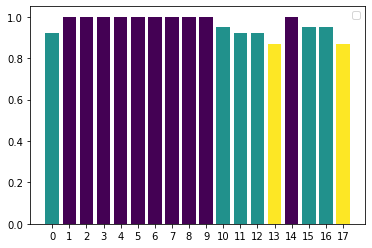

In [87]:
viridis = cm.get_cmap('viridis')
plt.bar(range(len(df['filename'])), df['fm'], color = viridis(normalize(df['number_of_clusters'] - 4)))
plt.xticks(range(len(df['filename'])), (str(x) for x in range(len(df['filename']))))
plt.show()

In [95]:
human_data_paths = list(Path("/chompsky/techno/development/work/clustering-data-cleaning/build/normalized").glob('*.json'))
human_data_path = human_data_paths[6]

In [1]:
stimulus = json.loads(human_data_path.read_bytes())[40]['clusters']
raw_data = utility.conv_mat_representation(stimulus)
raw_points = raw_data[:, :2]
raw_data

NameError: name 'json' is not defined

In [2]:
network = Network.generate_initial(raw_points)
network.plot(raw_points)

NameError: name 'Network' is not defined

19


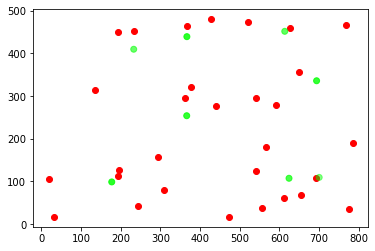

In [125]:
network.fit(raw_points)
network.plot(raw_points, False)
print(network.bottomk_number)